# 1. Предварительный анализ данных (EDA)
### Исследуем данные и их распределение

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')  # Отключаем все предупреждения

In [58]:
categories = pd.read_csv(r"D:\21vek\categories.csv")
sample_submission = pd.read_csv(r"D:\21vek\sample_submission.csv")
test = pd.read_csv(r"D:\21vek\test.csv")
train = pd.read_csv(r"D:\21vek\train.csv")

In [81]:
categories.head()

,CategoryID,CategoryName,Name_enhanced
0,0,Монитор,монитор
1,1,Мультимедиа акустика,мультимедиа акустика
2,2,Портативная акустика,портативный акустика
3,3,Чехол/защитное стекло для телефона,чехолзащитный стекло для телефон
4,4,Мобильный телефон,мобильный телефон


In [82]:
sample_submission.head()

,ID,CategoryID
0,0,3
1,15,3
2,21,3
3,22,3
4,24,3


In [83]:
test.head()

,ID,Query,Query_enhanced
0,0,xiaomi 2k gaming monitor g27qi p27qca-rggl,xiaomi 2k gaming monitor g27qi p27qcarggl
1,15,смартфон xiaomi redmi note 14 8gb/256gb (полун...,смартфон xiaomi redmi note 14 8gb256gb полуноч...
2,21,16 айфон,16 айфон
3,22,cmf buds pro,cmf buds pro
4,24,защитное стекло samsung galaxy a25,защитный стекло samsung galaxy a25


In [84]:
train.head()

,ID,CategoryID,Query,Query_enhanced
0,1,1,edifier,edifier
1,2,2,умная колонка яндекс станция лайт,умный колонка яндекс станция лайта
2,3,3,чехол iphone 14 pro,чехол iphone 14 pro
3,4,4,zte,zte
4,5,5,ноутбук huawei matebook b3-520 53012kfg,ноутбук huawei matebook b3520 53012kfg


In [59]:
# Объединение train и categories для анализа
train_cat = train.merge(categories, on='CategoryID')

In [85]:
train_cat.head()

,ID,CategoryID,Query,CategoryName,Query_length,Query_word_count
0,1,1,edifier,Мультимедиа акустика,7,1
1,2,2,умная колонка яндекс станция лайт,Портативная акустика,33,5
2,3,3,чехол iphone 14 pro,Чехол/защитное стекло для телефона,19,4
3,4,4,zte,Мобильный телефон,3,1
4,5,5,ноутбук huawei matebook b3-520 53012kfg,Ноутбук,39,5


Проверим наличие пропущенных значений и дубликатов

In [60]:
# Проверка на пропущенные значения
print("Пропуски в train:", train.isnull().sum())
print("Пропуски в test:", test.isnull().sum())

Пропуски в train: ID            0
CategoryID    0
Query         0
dtype: int64
Пропуски в test: ID       0
Query    0
dtype: int64


In [61]:
# Проверка на дубликаты
print("Дубликаты в train:", train.duplicated().sum())
print("Дубликаты в test:", test.duplicated().sum())

Дубликаты в train: 0
Дубликаты в test: 0


In [62]:
# Размеры выборок
print("Размеры train:", train.shape)
print("Размеры test:", test.shape)

Размеры train: (11558, 3)
Размеры test: (3899, 2)


Проанализируем основные характеристики запросов

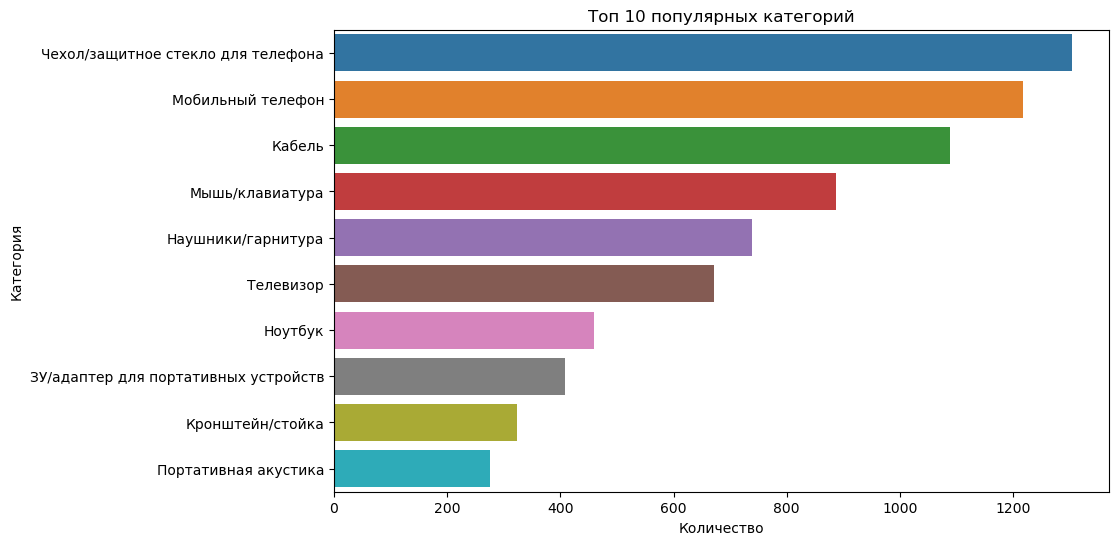

In [63]:
# Топ-10 категорий по частоте
top_categories = train_cat['CategoryName'].value_counts().head(10)
plt.figure(figsize=(10, 6))
sns.barplot(x=top_categories.values, y=top_categories.index)
plt.title('Топ 10 популярных категорий')
plt.xlabel('Количество')
plt.ylabel('Категория')
plt.show()

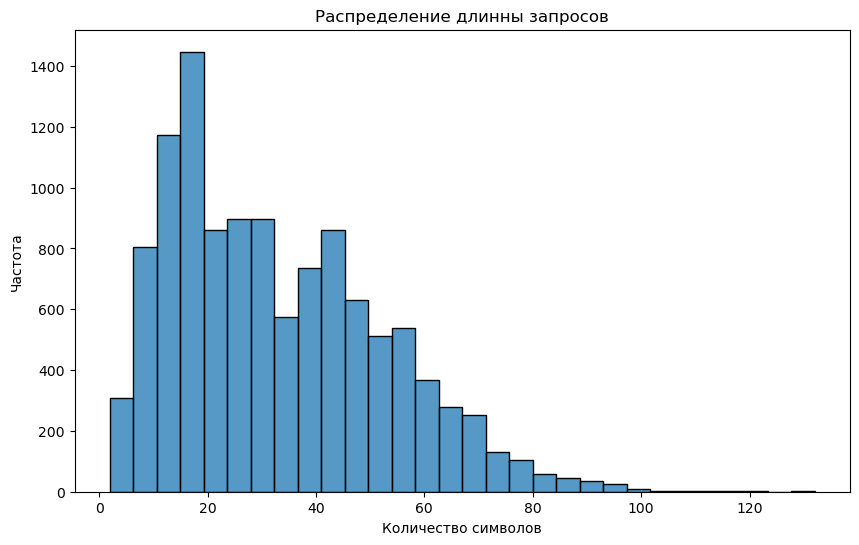

In [64]:
# Длина запросов в символах
train_cat['Query_length'] = train_cat['Query'].str.len()
plt.figure(figsize=(10, 6))
sns.histplot(train_cat['Query_length'], bins=30)
plt.title('Распределение длинны запросов')
plt.xlabel('Количество символов')
plt.ylabel('Частота')
plt.show()

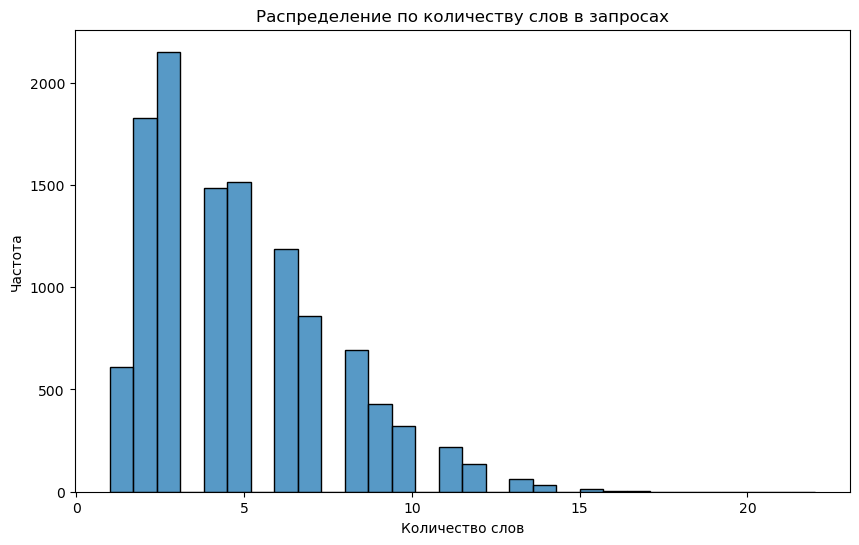

In [65]:
# Количество слов в запросах
train_cat['Query_word_count'] = train_cat['Query'].str.split().map(len)
plt.figure(figsize=(10, 6))
sns.histplot(train_cat['Query_word_count'], bins=30)
plt.title('Распределение по количеству слов в запросах')
plt.xlabel('Количество слов')
plt.ylabel('Частота')
plt.show()

Запросы в основном короткие (1–5 слов, 20–40 символов) и сосредоточены на популярных категориях, таких как телефоны и аксессуары.

# 2. Предобработка текста (запросов)
### Это должно помочь понизить шум и привести слова к единой форме

In [66]:
import re
import pymorphy3

In [67]:
# Инициализация морфологического анализатора
morph = pymorphy3.MorphAnalyzer()

In [68]:
def enhanced_normalizer(text):
    # Приведение к нижнему регистру и удаление лишних пробелов
    text = text.lower().strip()
    # Удаление знаков препинания
    text = re.sub(r'[^\w\s\d]', '', text)
    # Разделение на слова
    words = text.split()
    # Лемматизация слов
    words = [morph.parse(word)[0].normal_form for word in words]
    # Объединение слов обратно в строку
    return ' '.join(words)

In [69]:
# Применение нормализации
train['Query_enhanced'] = train['Query'].apply(enhanced_normalizer)
test['Query_enhanced'] = test['Query'].apply(enhanced_normalizer)
categories['Name_enhanced'] = categories['CategoryName'].apply(enhanced_normalizer)

In [70]:
train.head()

,ID,CategoryID,Query,Query_enhanced
0,1,1,edifier,edifier
1,2,2,умная колонка яндекс станция лайт,умный колонка яндекс станция лайта
2,3,3,чехол iphone 14 pro,чехол iphone 14 pro
3,4,4,zte,zte
4,5,5,ноутбук huawei matebook b3-520 53012kfg,ноутбук huawei matebook b3520 53012kfg


# 3. Векторизация и подготовка признаков

### Преобразуем текст в числовые векторы с помощью TF-IDF, чтобы выделить важные слова.

In [71]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Инициализация TF-IDF векторизатора
tfidf = TfidfVectorizer(
    max_features=10000,       # Ограничение на количество признаков
    ngram_range=(1, 2),       # Учет униграмм и биграмм
    min_df=2,                 # Минимум 2 документа для учета слова
    max_df=0.75,              # Игнорирование слов, встречающихся в >75% документов
    sublinear_tf=True         # Сублогарифмическое масштабирование
)

In [72]:
# Обучение и преобразование данных
X_train_tfidf = tfidf.fit_transform(train['Query_enhanced'])
X_test_tfidf = tfidf.transform(test['Query_enhanced'])
X_categories = tfidf.transform(categories['Name_enhanced'])

Добавим признаки, основанные на сходстве запросов с названиями категорий (матрица сходства)

In [73]:
from scipy.sparse import hstack

# Вычисление матрицы сходства для train
similarity_matrix = X_train_tfidf.dot(X_categories.T)
X_train_full = hstack([X_train_tfidf, similarity_matrix])

# Вычисление матрицы сходства для test
test_similarity = X_test_tfidf.dot(X_categories.T)
X_test_final = hstack([X_test_tfidf, test_similarity])

# Обучение моделей и предсказание

### Классические алгоритмы

In [74]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import make_scorer, f1_score

# Определяем scorer для F1 macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

LinearSVC

In [53]:
model_svc = LinearSVC(C=1, random_state=42, class_weight='balanced')
scores_svc = cross_val_score(model_svc, X_train_full, train['CategoryID'], cv=5, scoring=f1_macro_scorer)
print(f"LinearSVC F1 macro: {scores_svc.mean():.4f} (+/- {scores_svc.std():.4f})")

LinearSVC F1 macro: 0.8800 (+/- 0.0094)


LogisticRegression

In [54]:
model_lr = LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000)
scores_lr = cross_val_score(model_lr, X_train_full, train['CategoryID'], cv=5, scoring=f1_macro_scorer)
print(f"LogisticRegression F1 macro: {scores_lr.mean():.4f} (+/- {scores_lr.std():.4f})")

LogisticRegression F1 macro: 0.8706 (+/- 0.0122)


RandomForestClassifier

In [55]:
model_rf = RandomForestClassifier(random_state=42, n_jobs=-1)
scores_rf = cross_val_score(model_rf, X_train_full, train['CategoryID'], cv=5, scoring=f1_macro_scorer)
print(f"RandomForestClassifier F1 macro: {scores_rf.mean():.4f} (+/- {scores_rf.std():.4f})")

RandomForestClassifier F1 macro: 0.8340 (+/- 0.0132)


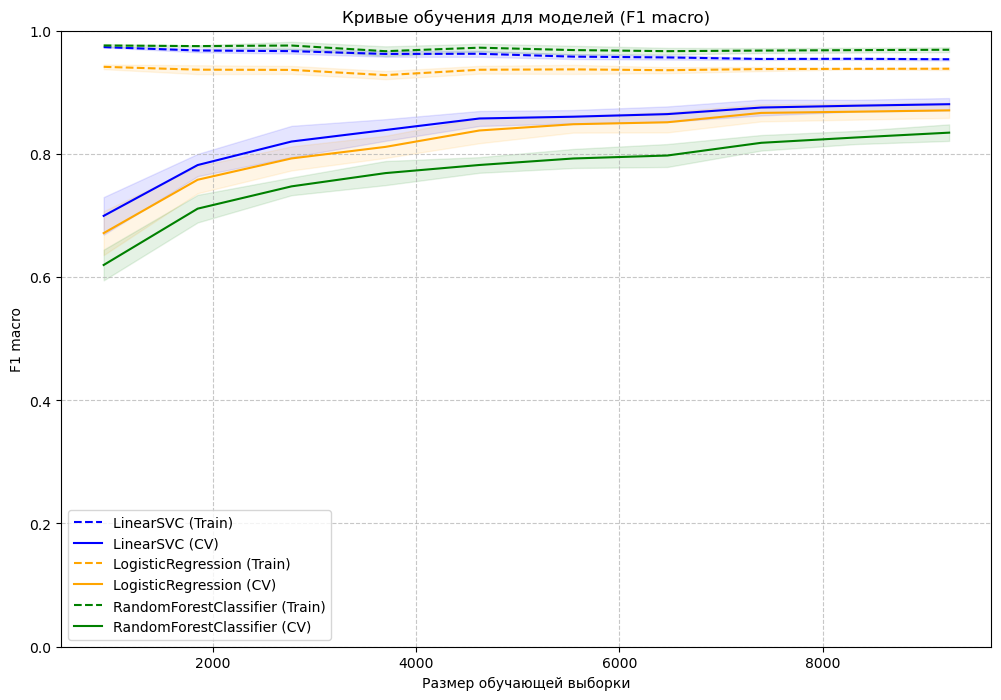

In [76]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, f1_score

# Определяем scorer для F1 macro
f1_macro_scorer = make_scorer(f1_score, average='macro')

# Список моделей
models = {
    'LinearSVC': LinearSVC(C=1, random_state=42, class_weight='balanced'),
    'LogisticRegression': LogisticRegression(random_state=42, class_weight='balanced', max_iter=1000),
    'RandomForestClassifier': RandomForestClassifier(random_state=42, n_jobs=-1)
}

# Функция для построения кривой обучения
def plot_learning_curves(estimator, X, y, label, color):
    train_sizes, train_scores, val_scores = learning_curve(
        estimator, X, y, cv=5, scoring=f1_macro_scorer, train_sizes=np.linspace(0.1, 1.0, 10), n_jobs=-1
    )
    
    train_mean = np.mean(train_scores, axis=1)
    train_std = np.std(train_scores, axis=1)
    val_mean = np.mean(val_scores, axis=1)
    val_std = np.std(val_scores, axis=1)

    plt.plot(train_sizes, train_mean, label=f'{label} (Train)', color=color, linestyle='--')
    plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color=color)
    plt.plot(train_sizes, val_mean, label=f'{label} (CV)', color=color)
    plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color=color)

# Построение графиков для всех моделей
plt.figure(figsize=(12, 8))

colors = ['blue', 'orange', 'green']
for i, (name, model) in enumerate(models.items()):
    plot_learning_curves(model, X_train_full, train['CategoryID'], name, colors[i])

# Настройка графика
plt.title('Кривые обучения для моделей (F1 macro)')
plt.xlabel('Размер обучающей выборки')
plt.ylabel('F1 macro')
plt.ylim(0, 1.0)
plt.legend(loc='best')
plt.grid(linestyle='--', alpha=0.7)
plt.show()

- **LinearSVC** демонстрирует наилучшую производительность (F1 macro ~0.8–0.85) с минимальным разрывом от обучающей выборки, что указывает на хорошее обобщение. Легкое переобучение можно устранить, уменьшив параметр `C`.
- **LogisticRegression** показывает стабильные результаты (F1 macro ~0.82) и может быть альтернативой с дополнительной настройкой.
- **RandomForestClassifier** сильно переобучается (F1 macro CV ~0.8–0.85 при Train = 1.0), что требует регуляризации (например, `max_depth` или `n_estimators`).
- Все модели достигают плато при 4000–6000 данных, что подтверждает достаточность текущего объема выборки.

### Подбор оптимального C для LinearSVC

На основе кривых обучения LinearSVC показывает лучшую производительность. Подберем оптимальное значение параметра `C` для улучшения обобщения.

In [77]:
# Диапазон значений C
C_values = np.arange(0.25, 2.25, 0.25)  # от 0.25 до 2.0 с шагом 0.25
f1_scores_mean = []
f1_scores_std = []

In [78]:
# Перебор значений C
for C in C_values:
    model = LinearSVC(C=C, random_state=42, class_weight='balanced')
    scores = cross_val_score(model, X_train_full, train['CategoryID'], cv=5, scoring=f1_macro_scorer, n_jobs=-1)
    f1_scores_mean.append(scores.mean())
    f1_scores_std.append(scores.std())
    print(f"C = {C:.2f}, F1 macro: {scores.mean():.4f} (+/- {scores.std():.4f})")

C = 0.25, F1 macro: 0.8788 (+/- 0.0075)
C = 0.50, F1 macro: 0.8801 (+/- 0.0093)
C = 0.75, F1 macro: 0.8803 (+/- 0.0089)
C = 1.00, F1 macro: 0.8806 (+/- 0.0100)
C = 1.25, F1 macro: 0.8787 (+/- 0.0128)
C = 1.50, F1 macro: 0.8775 (+/- 0.0121)
C = 1.75, F1 macro: 0.8745 (+/- 0.0128)
C = 2.00, F1 macro: 0.8751 (+/- 0.0132)


In [79]:
# Нахождение лучшего C
best_idx = np.argmax(f1_scores_mean)
best_C = C_values[best_idx]
best_f1 = f1_scores_mean[best_idx]
print(f"\nЛучшее значение C: {best_C:.2f}")
print(f"Лучший F1 macro: {best_f1:.4f}")


Лучшее значение C: 1.00
Лучший F1 macro: 0.8806


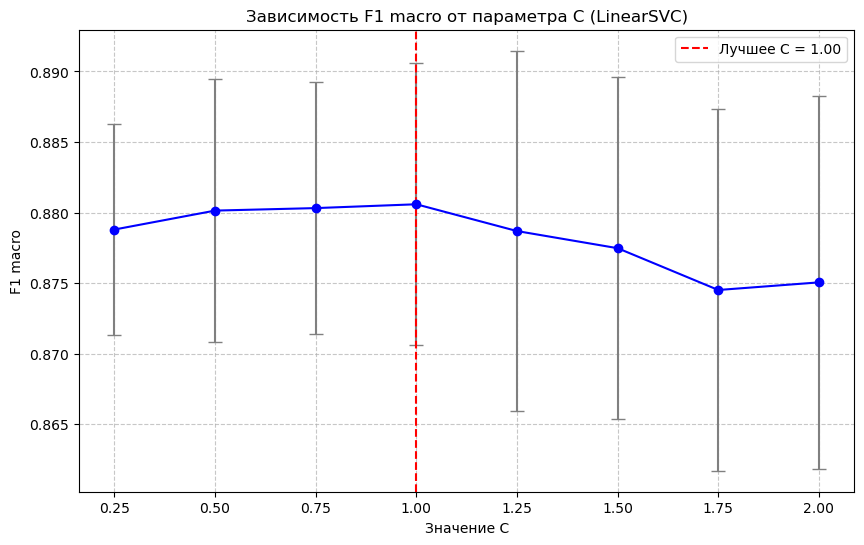

In [80]:
# Визуализация зависимости F1 macro от C
plt.figure(figsize=(10, 6))
plt.errorbar(C_values, f1_scores_mean, yerr=f1_scores_std, fmt='-o', capsize=5, color='blue', ecolor='gray')
plt.axvline(x=best_C, color='red', linestyle='--', label=f'Лучшее C = {best_C:.2f}')
plt.title('Зависимость F1 macro от параметра C (LinearSVC)')
plt.xlabel('Значение C')
plt.ylabel('F1 macro')
plt.legend()
plt.grid(linestyle='--', alpha=0.7)
plt.show()

Я попробоавал еще word2vec, fastext и трансформеры. 
- word2vec не удалаось поднять выше 0.78 f1 macro, пробовал локальную дообучать: сильно не помогло...
- fastext (tayga) дообученый показывал хороший f1 macro (0.86 на лог-реге), но загрузив на кагл, получил 0.72, в общем переобучилась модель, а полечить я это не смог :(
- из трансформеров искал что-то подходящее предобученное сначала попробовал deep-pavlov, он выдал ~0.6, решил мультиязычную попробовать, там вообще ниже 0.5 f1 macro вышел. 

В общем я не писал эти решения так как они вышли не очень удачными, да и опыта с ними сильно не было работы, но хоть познакомился и поирался немного)